# Coding part for Midterm.
Problems and cleaned codes shared here. 

<b>

GGD: A few thoughts and comments,

1.  The maps that are shown below are excellent!  Why the gaps in the FEMA maps?

2.  It would be very useful to have brief "data dictionaries" of your most important data sets.  What are the features?  What do those represent?  What are the range of values?  What is missing?

3.  Several of the ML ideas we had discussed in terms of classification and groupings rely on time series.  It would be good to include examples of those as well.

4.  Just to point out what I mentioned on Slack, for the midterm paper, there should be some linking text as to how these visualizations relate to the problem statement.

</b>

## Libraries (HA, DW, SS)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install geopandas
!pip install censusdata

In [0]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen
import requests
import censusdata as cd
plt.style.use("bmh")

## Shapefile (SS, DW, CW)
For US county boundaries

In [0]:
# -- get the zipfile
shp_url = 'http://www2.census.gov/geo/tiger/GENZ2015/shp/cb_2015_us_county_500k.zip'

shp_req = requests.get(shp_url)
z_shp = ZipFile(BytesIO(shp_req.content))
z_shp.extractall(path='tmp/')

In [9]:
# -- get the filenames
shp_filenames = [y for y in sorted(z_shp.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(shp_filenames)

['cb_2015_us_county_500k.dbf', 'cb_2015_us_county_500k.prj', 'cb_2015_us_county_500k.shp', 'cb_2015_us_county_500k.shx']


In [0]:
# -- save temporarily and read
dbf, prj, shp, shx = [filename for filename in shp_filenames]
co_shp = gp.read_file('tmp/' + shp)

In [0]:
# -- change GEOID to int so we can merge two dataframes
co_shp["GEOID"] = co_shp["GEOID"].astype(int)

In [0]:
# -- dataframe with just county FIPS
co_fips = pd.DataFrame(co_shp["GEOID"].values, columns = ["FIPS"])
co_fips

## Flood and Flash Flood Damage Data (CW, SS, DW)
The following table and figure depicts data sourced from the [Storm Events Database at NOAA](ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/). Direct losses for flood and flash flood events between the years of 1996 and 2019 were extracted for all counties in the US. The extracted NOAA data was merged with a table of all counties in the US through a [list provided by the USDA](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697). Features within this combined dataframe (named "noaa_geo") includes the Federal Information Processing Standards (FIPS) code for every county, the name of the county, associated state, associated shape file data, and the amount of annual direct damages experienced by each county between 1996 and 2019.

The figure depicts preliminary findings of total direct damages for all counties between 1996 and 2019. This offers a preliminary snapshot to understand geographical differences in the total cost of damages across the country. Notably, data is not represented for all states. This discrepency in the data requires further investigation and will be reviewed in the upcoming week.


In [0]:
## - Grab zone-county correlation file from NOAA and add columns
zcfile = "https://www.weather.gov/source/gis/Shapefiles/County/bp03mr20.dbx"
ztoc = pd.read_csv(zcfile, sep="|")

## - add column names
ztoc.columns = ["state", "zone_num", "CWAID", "zone_name", "state_zone", "county", "c_fips", "timezone", "fe_area", "lat", "lon"]

## - split county fips to state and county codes 
zcounty = ztoc['c_fips'].astype(int).astype(str)
zcounty = zcounty.str[-3:].astype(int)
ztoc["zcounty"] = zcounty

## - remove unnecessary columns
ztoc.drop(['state', 'CWAID', 'timezone', 'fe_area', 'lat', 'lon', 'zone_name', 'county'], axis=1, inplace=True)

In [29]:
ztoc.sort_values("c_fips")

,zone_num,state_zone,c_fips,zcounty
163,41,AL041,1001,1
191,264,AL264,1003,3
193,266,AL266,1003,3
189,262,AL262,1003,3
172,50,AL050,1005,5
...,...,...,...,...
3347,3,PR003,72151,151
3379,7,PR007,72153,153
4199,2,VI002,78010,10
4197,1,VI001,78020,20


In [0]:
from urllib.request import urlopen
import re

urlpath =urlopen('ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/')
string = urlpath.read().decode('utf-8')

pattern = re.compile(r'\bStormEvents_details-ftp_v1.0_d\S*?.gz') 
filelist = pattern.findall(string)

# -- get filename starting from 1996
csv = filelist[46:]
csv = ["ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d1996_c20170717.csv.gz","ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d1997_c20190920.csv.gz","ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d1998_c20170717.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d1999_c20190920.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2000_c20190920.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2001_c20190920.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2002_c20190920.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2003_c20190920.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2004_c20190920.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2005_c20190920.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2006_c20190920.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2007_c20170717.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2008_c20180718.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2009_c20180718.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2010_c20191116.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2011_c20180718.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2012_c20200317.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2013_c20170519.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2014_c20191116.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2015_c20191116.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2016_c20190817.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2017_c20200121.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2018_c20200317.csv.gz", "ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2019_c20200317.csv.gz" ]

# -- list of years, until 2019
year = list(range(1996,2020))

In [0]:
# -- loops through csv list for every year's file in noaa's website 
for i in range(len(csv)):
  # damage year column header as a string
  dmgyr = "dmg_"+str(year[i])
  
  # read the noaa csv file for the given year
  noaa_all = pd.read_csv(csv[i], skiprows=0)

  # pull data from storms events that influence flood damage
  noaa_all = noaa_all[(noaa_all["EVENT_TYPE"] ==  "Flash Flood") | 
                    (noaa_all["EVENT_TYPE"] == "Flood")].copy()

  '''
  noaa_all = noaa_all[(noaa_all["EVENT_TYPE"] == "Coastal Flood") | 
                    (noaa_all["EVENT_TYPE"] ==  "Flash Flood") | 
                    (noaa_all["EVENT_TYPE"] == "Flood") | 
                    (noaa_all["EVENT_TYPE"] == "Heavy Rain") | 
                    (noaa_all["EVENT_TYPE"] == "High Wind") | 
                    (noaa_all["EVENT_TYPE"] ==  "Hurricane") | 
                    (noaa_all["EVENT_TYPE"] == "Lakeshore Flood") | 
                    (noaa_all["EVENT_TYPE"] == "Marine High Wind") | 
                    (noaa_all["EVENT_TYPE"] ==  "Marine Strong Wind") | 
                    (noaa_all["EVENT_TYPE"] == "Marine Thunderstorm Wind") | 
                    (noaa_all["EVENT_TYPE"] == "Seiche") | 
                    (noaa_all["EVENT_TYPE"] == "Storm Surge/Tide") | 
                    (noaa_all["EVENT_TYPE"] == "Thunderstorm Wind") | 
                    (noaa_all["EVENT_TYPE"] == "Tropical Depression") | 
                    (noaa_all["EVENT_TYPE"] == "Tropical Storm")].copy()
  '''
  # convert DAMAGE_TYPE values from string to int
  noaa_all[dmgyr] = (noaa_all['DAMAGE_PROPERTY'].replace(r'[KMB]+$', ' ', regex=True).replace(' ',np.nan).astype(float) * noaa_all['DAMAGE_PROPERTY'].str.extract(r'[\d\.]+([KM]+)',expand=False).fillna(1).replace(['K','M','B'],[10**3,10**6,10**9]).astype(int))

  # construct a state+county ID, so all counties have unique identifier
  state = noaa_all["STATE_FIPS"].astype(int).astype(str)
  county = noaa_all["CZ_FIPS"].astype(int).astype(str)
  county = "00"+ county 
  county = county.str[-3:]
  geoid = (state + county).astype(int)
  noaa_all["STATE_CO_FIPS"] = geoid
  noaa_all= noaa_all[noaa_all["STATE_CO_FIPS"]<79000]

  # extract state FIPS, county name, county FIPS, and property damage values
  noaa_small = noaa_all[['STATE_CO_FIPS',dmgyr]].copy()

  # group by county name and sum total damages per county for this year
  noaa_smallg = noaa_small.groupby("STATE_CO_FIPS").sum()
  #print("The total sum of damages for flood and flash flood events in "+str(year[i])+" is ${}".format(noaa_smallg[dmgyr].sum()))

  # merge onto compiled dataframe
  #noall = co_fips.reset_index().merge(noaa_smallg,left_on="FIPS", right_on="STATE_CO_FIPS", how ='outer').set_index('index')
  noall = co_fips.merge(noaa_smallg,left_on="FIPS", right_on="STATE_CO_FIPS", how ='outer')
  co_shp[dmgyr] = noall[dmgyr].copy() 

In [0]:
# -- sum up the total damage from 1996-2019
co_shp['dmg_sum'] = co_shp.iloc[:,10:].sum(axis=1)

co_shp

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,dmg_1996,dmg_1997,dmg_1998,dmg_1999,dmg_2000,dmg_2001,dmg_2002,dmg_2003,dmg_2004,dmg_2005,dmg_2006,dmg_2007,dmg_2008,dmg_2009,dmg_2010,dmg_2011,dmg_2012,dmg_2013,dmg_2014,dmg_2015,dmg_2016,dmg_2017,dmg_2018,dmg_2019,dmg_sum
0,01,005,00161528,0500000US01005,1005,Barbour,06,2291820706,50864677,"POLYGON ((-85.74803 31.61918, -85.74544 31.618...",NaN,NaN,110000.0,NaN,NaN,25000.0,NaN,NaN,3000.0,NaN,NaN,NaN,NaN,30000.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,168000.0
1,01,023,00161537,0500000US01023,1023,Choctaw,06,2365954971,19059247,"POLYGON ((-88.47323 31.89386, -88.46888 31.930...",NaN,501000.0,50000.0,8000.0,0.0,17000.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,75000.0,0.0,25000.0,NaN,NaN,0.0,1200000.0,0.0,0.0,725000.0,25000.0,2626000.0
2,01,035,00161543,0500000US01035,1035,Conecuh,06,2201896058,6643480,"POLYGON ((-87.42720 31.26436, -87.42551 31.268...",NaN,NaN,300000.0,2000.0,NaN,15000.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,100000.0,NaN,NaN,NaN,NaN,NaN,417000.0
3,01,051,00161551,0500000US01051,1051,Elmore,06,1601876535,99850740,"POLYGON ((-86.41333 32.75059, -86.37115 32.750...",10000.0,10000.0,25000.0,23000.0,20000.0,24000.0,NaN,92000.0,15000.0,52000.0,0.0,0.0,NaN,4902000.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,5173000.0
4,01,065,00161558,0500000US01065,1065,Hale,06,1667804583,32525874,"POLYGON ((-87.87046 32.76244, -87.86818 32.765...",NaN,NaN,30000.0,NaN,NaN,NaN,NaN,12000.0,NaN,8000.0,NaN,NaN,NaN,25000.0,10000.0,75000.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,160000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,45,019,01252740,0500000US45019,45019,Charleston,06,2372842394,1144346152,"MULTIPOLYGON (((-79.50795 33.02008, -79.50713 ...",25000.0,125000.0,413500.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,3000.0,112500.0,34000.0,4500.0,5000.0,760000.0,100000.0,54000.0,18323750.0,0.0,50000.0,22500.0,NaN,20032750.0
3229,45,077,01248015,0500000US45077,45077,Pickens,06,1285536060,40612589,"MULTIPOLYGON (((-82.86687 34.61742, -82.86451 ...",NaN,0.0,50000.0,NaN,0.0,0.0,NaN,0.0,0.0,400000.0,50000.0,0.0,NaN,NaN,0.0,NaN,NaN,450000.0,100000.0,10000.0,NaN,NaN,500.0,1000.0,1061500.0
3230,46,123,01265784,0500000US46123,46123,Tripp,06,4176233698,13272785,"POLYGON ((-100.23091 43.49989, -100.23044 43.5...",NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,200000.0,NaN,NaN,NaN,250000.0,0.0,0.0,0.0,NaN,10000.0,0.0,1000.0,10000.0,NaN,0.0,0.0,471000.0
3231,47,073,01639752,0500000US47073,47073,Hawkins,06,1261443215,32545400,"POLYGON ((-83.28890 36.37879, -83.28250 36.382...",0.0,NaN,0.0,0.0,NaN,NaN,0.0,8000.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,10000.0,NaN,1000.0,NaN,NaN,NaN,2000.0,21000.0


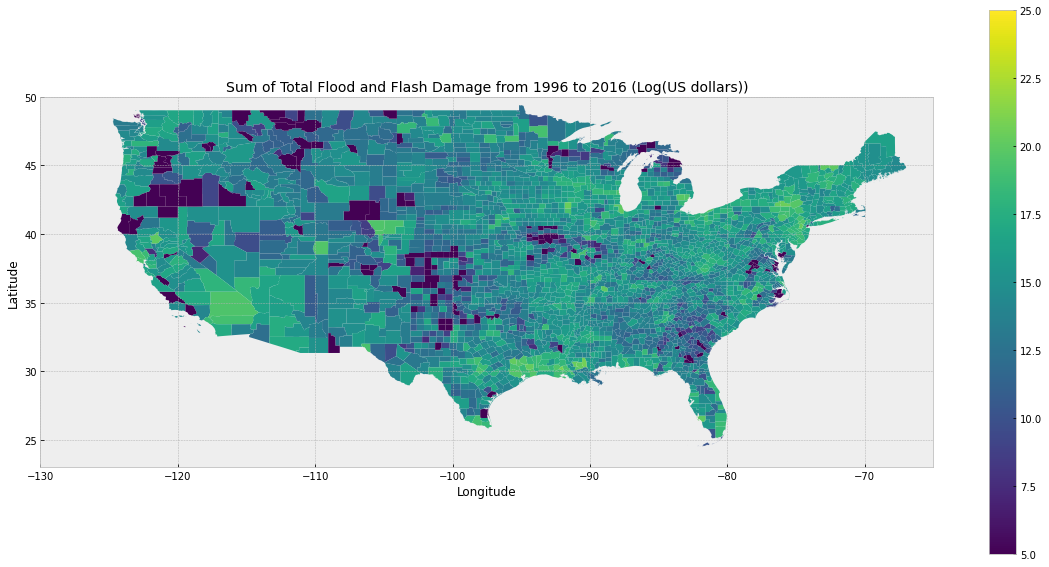

In [0]:
# -- make a choropleth for log of sum of damage from 1996 to 2019
fig, ax = plt.subplots(figsize=[20, 10])

#co_shp.plot(co_shp['dmg_sum'], vmin=0, vmax=co_shp['dmg_sum'].max(),legend=True, ax=ax)
co_shp.plot(co_shp['dmg_sum'].agg(np.log), vmin=5, vmax=25,legend=True, ax=ax)
ax.set_xlim([-130,-65])
ax.set_ylim([23,50])
ax.set_title("Sum of Total Flood and Flash Damage from 1996 to 2016 (Log(US dollars))", loc="center", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.show()

## CENSUS Data (SS, DW, HA, CW)
The following table and figures utilizes the [Census Data python package](https://jtleider.github.io/censusdata/api.html#censusdata.download.geographies) with data sourced from the [US Census Bureau](https://www.census.gov/quickfacts/fact/table/US/PST045219). The information available in the dataframe displays data from 2018. Key features include the total population (total_pop), total white population (total_white), tolal people who obtained a high school diploma (high_sch), median income (med_inc), median home value (housing) for every county in the US. The figures show the differences in economic and demographic data across the US for the year 2018. The log of the population was chosen, opposed to the natural values, to better display the population nuances across the entire US. It can be noted that while the percentage of white population figure is relatively uniform, except in the southern region of the US, the percentage of people with high school diplomas varies more across the US. City centers are highlighted in the Median Income figure, representing economic differences with the urban/rural divide. This socio-economic data will be used for further analysis to better understand flood vulnerability throughout the US.


In [0]:
# -- set the needed variables and new column name
var_cs = ['B01003_001E','B02001_002E', 'B15003_017E','B19013_001E','B25075_001E']
var_cs_name = ['index','total_pop', 'white_pop', 'high_sch', 'med_income', 'housing','year','county']

In [0]:
# -- get census data from 2012-2018
census_all = []
for i in range(2012, 2019):
  county_cs = cd.download('acs5', i, cd.censusgeo([('county', '*')]), var_cs).reset_index()
  county_cs['index'] = county_cs['index'].agg(str)
  county_cs['year'] = i

  # -- split index, get county and state index 
  sp1 =  county_cs['index'].str.split("> county:",expand=True)
  county_no = sp1[1]

  sp2 = sp1[0].str.split("state:",expand =True)
  state_no = sp2[1]
   
  # -- get countycode
  countycode_cs = (state_no+county_no).astype(int)
  county_cs['countycode']=countycode_cs 
  
  census_all.append(county_cs)


In [0]:
census_all = pd.concat(census_all, ignore_index=True)
census_all.columns = var_cs_name
# note that in Y2012-2013 have 3221 counties, Y2014-2018 have 3220 counties.

In [0]:
# -- get the percentage of education level high than high school diplomas and white population
census_all['high_edu_pct'] = census_all['high_sch']/census_all['total_pop'] *100
census_all['white_pct'] = census_all['white_pop']/census_all['total_pop'] *100
census_all['non-white_pct'] = 100 - census_all['white_pct']


In [0]:
# -- get the latest demographic data
census_2018 = census_all[census_all['year']==2018].copy()
census_2018_geo =  co_shp.merge(census_2018,left_on="GEOID", right_on="county").copy()
census_2018_geo.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,dmg_1996,dmg_1997,dmg_1998,dmg_1999,dmg_2000,dmg_2001,dmg_2002,dmg_2003,dmg_2004,dmg_2005,dmg_2006,dmg_2007,dmg_2008,dmg_2009,dmg_2010,dmg_2011,dmg_2012,dmg_2013,dmg_2014,dmg_2015,dmg_2016,dmg_2017,dmg_2018,dmg_2019,dmg_sum,index,total_pop,white_pop,high_sch,med_income,housing,year,county,high_edu_pct,white_pct,non-white_pct
0,01,005,00161528,0500000US01005,1005,Barbour,06,2291820706,50864677,"POLYGON ((-85.74803 31.61918, -85.74544 31.618...",NaN,NaN,110000.0,NaN,NaN,25000.0,NaN,NaN,3000.0,NaN,NaN,NaN,NaN,30000.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,168000.0,"Barbour County, Alabama: Summary level: 050, s...",25782,12216,5040,34186.0,5640,2018,1005,19.548522,47.381894,52.618106
1,01,023,00161537,0500000US01023,1023,Choctaw,06,2365954971,19059247,"POLYGON ((-88.47323 31.89386, -88.46888 31.930...",NaN,501000.0,50000.0,8000.0,0.0,17000.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,75000.0,0.0,25000.0,NaN,NaN,0.0,1200000.0,0.0,0.0,725000.0,25000.0,2626000.0,"Choctaw County, Alabama: Summary level: 050, s...",13075,7420,2999,34884.0,4263,2018,1023,22.936902,56.749522,43.250478
2,01,035,00161543,0500000US01035,1035,Conecuh,06,2201896058,6643480,"POLYGON ((-87.42720 31.26436, -87.42551 31.268...",NaN,NaN,300000.0,2000.0,NaN,15000.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,100000.0,NaN,NaN,NaN,NaN,NaN,417000.0,"Conecuh County, Alabama: Summary level: 050, s...",12514,6369,3752,33177.0,3504,2018,1035,29.982420,50.894998,49.105002
3,01,051,00161551,0500000US01051,1051,Elmore,06,1601876535,99850740,"POLYGON ((-86.41333 32.75059, -86.37115 32.750...",10000.0,10000.0,25000.0,23000.0,20000.0,24000.0,NaN,92000.0,15000.0,52000.0,0.0,0.0,NaN,4902000.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,5173000.0,"Elmore County, Alabama: Summary level: 050, st...",81212,60824,14000,59347.0,21480,2018,1051,17.238832,74.895336,25.104664
4,01,065,00161558,0500000US01065,1065,Hale,06,1667804583,32525874,"POLYGON ((-87.87046 32.76244, -87.86818 32.765...",NaN,NaN,30000.0,NaN,NaN,NaN,NaN,12000.0,NaN,8000.0,NaN,NaN,NaN,25000.0,10000.0,75000.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,160000.0,"Hale County, Alabama: Summary level: 050, stat...",14887,5898,3542,30571.0,4044,2018,1065,23.792571,39.618459,60.381541


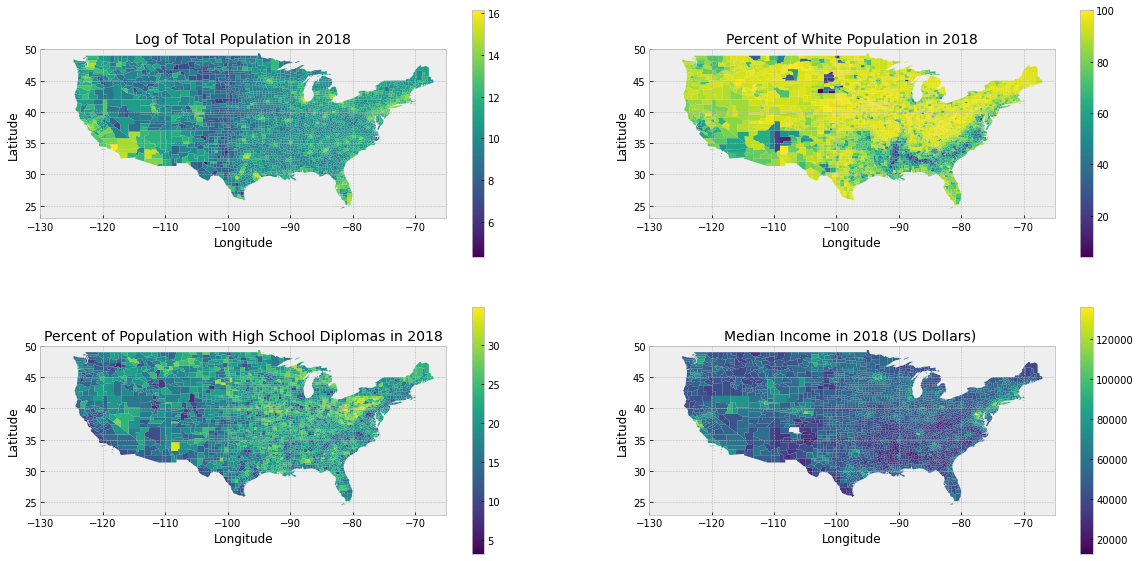

In [0]:
# -- mchoropleth for 2018 data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize = [20,10])

census_2018_geo.plot(census_2018_geo['total_pop'].agg(np.log), legend=True,  ax=ax1)
ax1.set_xlim([-130,-65])
ax1.set_ylim([23,50])
ax1.set_title("Log of Total Population in 2018", loc="center", fontsize=14)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
fig.show()

census_2018_geo.plot('white_pct', legend=True, ax=ax2)
ax2.set_xlim([-130,-65])
ax2.set_ylim([23,50])
ax2.set_title("Percent of White Population in 2018", loc="center", fontsize=14)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
fig.show()

census_2018_geo.plot('high_edu_pct', legend=True, ax=ax3)
ax3.set_xlim([-130,-65])
ax3.set_ylim([23,50])
ax3.set_title("Percent of Population with High School Diplomas in 2018", loc="center", fontsize=14)
ax3.set_xlabel("Longitude")
ax3.set_ylabel("Latitude")
fig.show()

census_2018_geo.plot('med_income', legend=True, ax=ax4)
ax4.set_xlim([-130,-65])
ax4.set_ylim([23,50])
ax4.set_title("Median Income in 2018 (US Dollars) ", loc="center", fontsize=14)
ax4.set_xlabel("Longitude")
ax4.set_ylabel("Latitude")
fig.show()

## FEMA Data (DW, SS)
https://www.fema.gov/media-library/assets/documents/180374

The following tables and figures includes data regarding insurance policies and claims sourced from [FEMA](https://www.fema.gov/media-library-data/1575491579309-2366ee38d902c1bc983370e132ee36cc/FIMA_NFIP_Redacted_Claims_Data_Set.zip). Specifically the data is sourced from the "Federal Insurance & Mitigation Administration National Flood Insurance Program (FIMA NFIP) Redacted Claims Dataset", which includes data about the insurance protection, the damage claims and also a rating system.The insurance claims sums the total claims for building damages, contents damages, and increased cost of compliance. The total insurance coverage data, available in the last column in the table, combines total building and contents coverage. The figures show a differences in insurance claim payments and insurance coverages across the US, using a log scale. A log scale was used to better highlight the counties with significant insurance coverage and claims. From the figure it can be seen that although data is not completed in the Central US, the Southeast has more money paid by FEMA. The "insurance covered" looks more evenly distributed than the "claims paid" value, which means the insurance policy is not as varied. This data will help us to begin to assess the effectiveness of the government's risk management policies.

In [14]:
# -- get the FEMA zipfile name
fname_fema = "https://www.fema.gov/media-library-data/1575491579309-2366ee38d902c1bc983370e132ee36cc/FIMA_NFIP_Redacted_Claims_Data_Set.zip"

zipfile = ZipFile(BytesIO(urlopen(fname_fema).read()))
zipfile.namelist()

['NFIP Claims Instructions and Metadata.xlsx', 'openFEMA_claims20190831.csv']

In [15]:
# -- read the table
file = 'openFEMA_claims20190831.csv'
FEMA_claims_all = pd.read_csv(zipfile.open(file))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,11,15,22,23,31,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
FEMA_claims_all

In [0]:
# -- extract useful columns and data 
FEMA_claims_sorted = FEMA_claims_all[FEMA_claims_all['yearofloss'] >= 1996]
FEMA_claims_sorted = FEMA_claims_sorted[['reportedcity','countycode', 'crsdiscount', 'yearofloss',
                                         'amountpaidonbuildingclaim','amountpaidoncontentsclaim','amountpaidonincreasedcostofcomplianceclaim',
                                         'totalbuildinginsurancecoverage', 'totalcontentsinsurancecoverage']]

In [19]:
FEMA_claims_sorted

,reportedcity,countycode,crsdiscount,yearofloss,amountpaidonbuildingclaim,amountpaidoncontentsclaim,amountpaidonincreasedcostofcomplianceclaim,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage
0,OCEANSIDE,6073.0,0.00,1998,0.00,0.00,NaN,200000.0,50000.0
1,NEW ORLEANS,22071.0,0.00,2005,0.00,0.00,NaN,100000.0,40000.0
2,NAVARRE,12113.0,0.05,1998,8813.21,1720.00,0.0,100000.0,50000.0
4,MELBOURNE,12009.0,0.00,1996,3875.53,1545.00,NaN,100000.0,25000.0
5,VIRGINIA BEACH,51810.0,0.00,1998,14985.92,1510.00,0.0,88000.0,12600.0
...,...,...,...,...,...,...,...,...,...
2432883,MIAMI,12086.0,0.25,2005,4390.96,1732.31,0.0,131000.0,45000.0
2432884,MIAMI,12086.0,0.25,2005,3541.59,1469.29,0.0,153300.0,76700.0
2432885,PINECREST,12086.0,0.25,2005,8335.35,0.00,0.0,245000.0,100000.0
2432886,PINECREST,12086.0,0.25,2005,2396.44,0.00,0.0,245000.0,100000.0


In [0]:
# -- sum up and select useful columns
FEMA_claims_sorted['totalpaid']=FEMA_claims_sorted[['amountpaidonbuildingclaim','amountpaidoncontentsclaim','amountpaidonincreasedcostofcomplianceclaim']].sum(axis=1)
FEMA_claims_sorted['totalcovered']=FEMA_claims_sorted[['totalbuildinginsurancecoverage', 'totalcontentsinsurancecoverage']].sum(axis=1)
FEMA_claims = FEMA_claims_sorted[['reportedcity', 'countycode', 'crsdiscount', 'yearofloss','totalpaid', 'totalcovered']].copy()

In [0]:
# -- get the sum of paid and covered from 1996-2019 by county
paid_total = FEMA_claims.groupby(['countycode'])[['totalpaid']].sum().reset_index().copy()
covered_total = FEMA_claims.groupby(['countycode'])[['totalcovered']].sum().reset_index().copy()
total = paid_total.merge(covered_total,left_on="countycode", right_on="countycode").copy()

In [22]:
total

,countycode,totalpaid,totalcovered
0,1001.0,8.284555e+05,7.201700e+06
1,1003.0,5.023391e+08,5.833974e+09
2,1005.0,6.392535e+05,2.033200e+06
3,1007.0,4.355140e+03,3.597000e+05
4,1009.0,6.178420e+05,2.694000e+06
...,...,...,...
2883,72151.0,3.876451e+05,6.259200e+06
2884,72153.0,1.265391e+06,5.918800e+06
2885,78010.0,2.177374e+07,1.806121e+08
2886,78020.0,1.623229e+05,7.287000e+05


In [0]:
# -- merge previous dataframe onto shapefile
total_geo =  co_shp.merge(total,left_on="GEOID", right_on="countycode").copy()

In [0]:
# -- get log values for better plot
total_geo['lgtotalp']=total_geo['totalpaid'].agg(np.log)
total_geo['lgtotalc']=total_geo['totalcovered'].agg(np.log)

In [0]:
total_geo

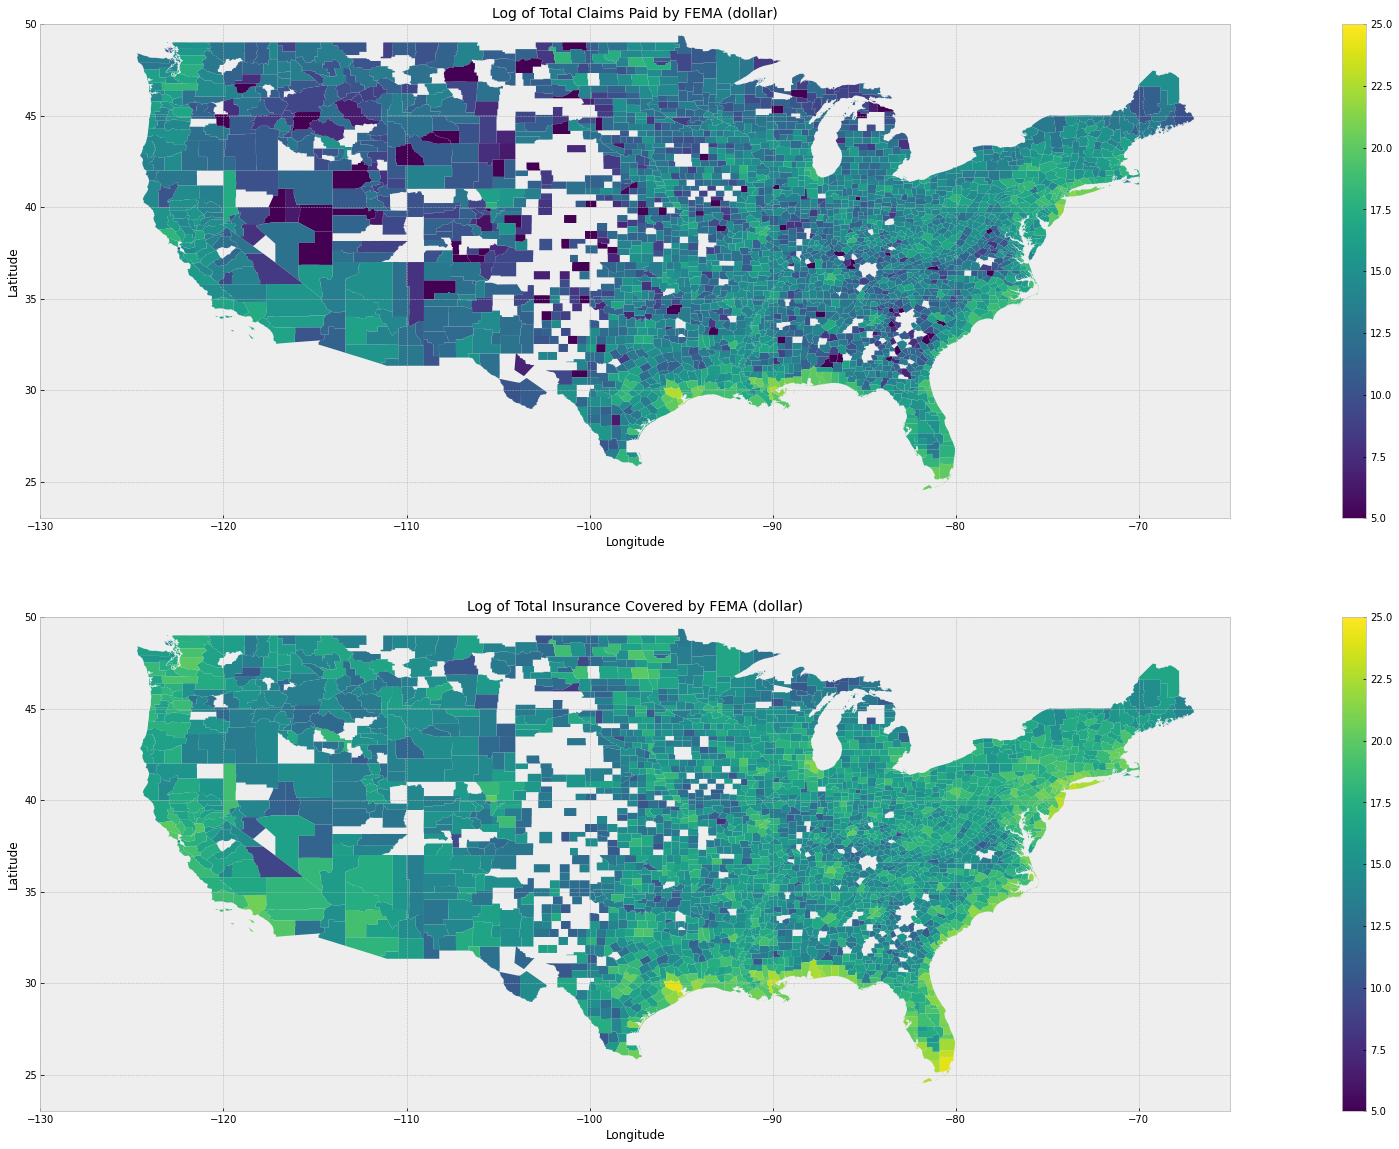

In [26]:
# -- make a choropleth for sum of log 1996 - 2019, paid and covered
fig, ax = plt.subplots(2,1,figsize=[40, 20])

total_geo.plot('lgtotalp', legend=True, vmin=5, vmax= 25, ax=ax[0])
ax[0].set_xlim([-130,-65])
ax[0].set_ylim([23,50])
ax[0].set_title("Log of Total Claims Paid by FEMA (dollar)", loc="center", fontsize=14)
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
fig.show()

total_geo.plot('lgtotalc', legend=True, vmin=5, vmax= 25, ax=ax[1])
ax[1].set_xlim([-130,-65])
ax[1].set_ylim([23,50])
ax[1].set_title("Log of Total Insurance Covered by FEMA (dollar)", loc="center", fontsize=14)
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")
fig.show()